In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit


In [ ]:
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(int),
         'PromoInterval': np.dtype(str)}

In [ ]:
train_tmp = pd.read_csv("/content/drive/My Drive/Project_3/Dataset/train.csv", dtype = types)
 
train_tmp = train_tmp[train_tmp.Sales > 0]
store = pd.read_csv("/content/drive/My Drive/Project_3/Dataset/store.csv")

train = pd.merge(train_tmp, store, on = 'Store')

In [ ]:
 
test_tmp = pd.read_csv("/content/drive/My Drive/Project_3/Dataset/test.csv", dtype = types)
test = pd.merge(test_tmp, store, on = 'Store')

In [ ]:
 
test.loc[(test.Open.isnull()), 'Open'] = 1
train.loc[(train.CompetitionDistance.isnull()), 'CompetitionDistance'] = train['CompetitionDistance'].mean()
test.loc[(test.CompetitionDistance.isnull()), 'CompetitionDistance'] = test['CompetitionDistance'].mean()

In [ ]:

train['Year'] = pd.to_datetime(train['Date']).dt.year
train['Month'] = pd.to_datetime(train['Date']).dt.month
train['Day'] = pd.to_datetime(train['Date']).dt.day
st_dic = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
as_dic = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
train['StoreType1'] = train['StoreType'].map(st_dic).astype(int)
train['Assortment1'] = train['Assortment'].map(as_dic).astype(int)
  
test['Year'] = pd.to_datetime(test['Date']).dt.year
test['Month'] = pd.to_datetime(test['Date']).dt.month
test['Day'] = pd.to_datetime(test['Date']).dt.day
test['StoreType1'] = test['StoreType'].map(st_dic).astype(int)
test['Assortment1'] = test['Assortment'].map(as_dic).astype(int)

In [ ]:

train['Sales'] = np.log(train['Sales']+1)
average_sales = np.exp(train['Sales'].mean())
print ("Average sales : " + str(average_sales))

Average sales : 6359.701905658759


In [ ]:
labels_train = train['Sales'].values
print(train['Sales'])
labels_train

0         8.568646
1         8.521384
2         8.472823
3         8.519590
4         8.716536
            ...   
844333    9.136909
844334    7.918992
844335    8.343554
844336    8.429673
844337    8.532476
Name: Sales, Length: 844338, dtype: float64


array([8.56864647, 8.5213844 , 8.47282324, ..., 8.34355384, 8.42967259,
       8.53247581])

In [ ]:
features_to_drop_store = ['StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Promo2']

features_to_drop_train = ['StateHoliday', 'Open', 'SchoolHoliday', 'Date', 'Customers', 'Sales']
features_to_drop_test =  ['StateHoliday', 'Open', 'SchoolHoliday', 'Date']


In [ ]:
train = train.drop(features_to_drop_train, axis = 1)
train = train.drop(features_to_drop_store, axis = 1)

In [ ]:
test_ID = test['Id']

test = test.drop(features_to_drop_test, axis = 1)
test = test.drop(features_to_drop_store, axis = 1)

In [ ]:
features_train = train.values
features_test = test.values
print(features_test)

[[1.0000e+00 1.0000e+00 4.0000e+00 ... 1.7000e+01 3.0000e+00 1.0000e+00]
 [8.5700e+02 1.0000e+00 3.0000e+00 ... 1.6000e+01 3.0000e+00 1.0000e+00]
 [1.7130e+03 1.0000e+00 2.0000e+00 ... 1.5000e+01 3.0000e+00 1.0000e+00]
 ...
 [3.9376e+04 1.1150e+03 1.0000e+00 ... 3.0000e+00 4.0000e+00 3.0000e+00]
 [4.0232e+04 1.1150e+03 7.0000e+00 ... 2.0000e+00 4.0000e+00 3.0000e+00]
 [4.1088e+04 1.1150e+03 6.0000e+00 ... 1.0000e+00 4.0000e+00 3.0000e+00]]


In [ ]:
model1 = RandomForestRegressor(n_estimators = 10, n_jobs = -1, max_depth = 2000)

params = {"n_estimators":[10, 20, 50],"min_samples_split":[5, 10, 50]}
cv_rf = GridSearchCV(model1, param_grid=params, n_jobs=1, cv=3)
cv_rf.fit(features_train, labels_train)
print(cv_rf.best_params_)
print(cv_rf.best_estimator_)
 
cv_ssplit = ShuffleSplit(n_splits=5, test_size=0.2, random_state=2)
cv_score = cross_val_score(model1, features_train, labels_train,cv=cv_ssplit, scoring = 'r2')
print ("Cross Validation Accuracy: %0.4f +/- %0.4f" % (cv_score.mean(), cv_score.std()))
 
model1 = model1.fit(features_train, labels_train)
pred_train = model1.predict(features_train)
 
from math import sqrt
rmspe = 0
for i in range(1,len(pred_train)):
   rmspe = rmspe + ((np.exp(labels_train[i]) - np.exp(pred_train[i]))/np.exp(labels_train[i]))**2
rmspe = math.sqrt(rmspe/len(pred_train))
print('RMSPE on train set = ' + str(round(rmspe,4)))
 
pred_test = model1.predict(features_test)
pred_test = np.exp(pred_test) - 1 

pred_sales = pd.DataFrame(dict(Sales = pred_test, Id = test_ID))
pred_sales = pred_sales.sort_values(by = 'Id')
red_sales.to_csv('./sales1.csv', index = False)
 
 # Average accuracy: 0.8411 +/- 0.0038
 # RMSPE on train set = 0.0722

 # Cross Validation Accuracy: 0.8939 +/- 0.0012
 # RMSPE on train set = 0.0593

In [ ]:
model2 = LinearRegression()
params = {"fit_intercept" : [True] , "n_jobs" : [None]}

cv_rf = GridSearchCV(model2, param_grid=params, n_jobs=1, cv=3)
cv_rf.fit(features_train, labels_train)
print(cv_rf.best_params_)
print(cv_rf.best_estimator_)

# Cross-validation
cv_ssplit = ShuffleSplit(n_splits=5, test_size=0.2, random_state=3)
cv_score = cross_val_score(model2,features_train, labels_train,cv=cv_ssplit, scoring = 'r2')

print ("Cross Validation Accuracy: %0.4f +/- %0.4f" % (cv_score.mean(), cv_score.std()))

model2 = model2.fit(features_train, labels_train)
pred_train = model2.predict(features_train)

from math import sqrt
rmspe = 0
for i in range(1,len(pred_train)):
    rmspe = rmspe + ((np.exp(labels_train[i]) - np.exp(pred_train[i]))/np.exp(labels_train[i]))**2
rmspe = math.sqrt(rmspe/len(pred_train))
print('RMSPE on train set = ' + str(round(rmspe,4)))


pred_test = model2.predict(features_test)
pred_test = np.exp(pred_test) - 1 
print(pred_test)

pred_sales = pd.DataFrame(dict(Sales = pred_test, Id = test_ID))
pred_sales = pred_sales.sort_values(by = 'Id')
pred_sales.to_csv('./sales2.csv', index = False)



 # Average accuracy: 0.1936 +/- 0.0015
 # RMSPE on train set = 0.4717


# Cross Validation Accuracy: 0.1959 +/- 0.0015
# RMSPE on train set = 0.4688

In [ ]:
#fig, ax = plt.subplots(figsize=(15,7))
# features_train.groupby('CompetitionDistance')['Sales'].plot(kind = 'bar', legend = True, label = 'Avg. Sales')
# type(features_train)

In [ ]:
model3 = GradientBoostingRegressor()
params = {"n_estimators":[5, 10, 50],"min_samples_split":[5, 10, 50]}
cv_rf = GridSearchCV(model3, param_grid=params, n_jobs=1, cv=3)
cv_rf.fit(features_train, labels_train)
print(cv_rf.best_params_)
print(cv_rf.best_estimator_)

cv_ssplit = ShuffleSplit(n_splits=5, test_size=0.2, random_state=3)
cv_score = cross_val_score(model3,features_train, labels_train,cv=cv_ssplit, scoring = 'r2')

print ("Cross Validation Accuracy: %0.4f +/- %0.4f" % (cv_score.mean(), cv_score.std()))

model2 = model3.fit(features_train, labels_train)
pred_train = model3.predict(features_train)

from math import sqrt
rmspe = 0
for i in range(1,len(pred_train)):
    rmspe = rmspe + ((np.exp(labels_train[i]) - np.exp(pred_train[i]))/np.exp(labels_train[i]))**2
rmspe = math.sqrt(rmspe/len(pred_train))
print('RMSPE on train set = ' + str(round(rmspe,4)))


pred_test = model3.predict(features_test)
pred_test = np.exp(pred_test) - 1

pred_sales = pd.DataFrame(dict(Sales = pred_test, Id = test_ID))
pred_sales = pred_sales.sort_values(by = 'Id')
pred_sales.to_csv('./sales3.csv', index = False)
# Average accuracy: 0.3319 +/- 0.0030
# RMSPE on train set = 0.4282


# Cross Validation Accuracy: 0.3572 +/- 0.0026
# RMSPE on train set = 0.417

In [ ]:
model4 = AdaBoostingRegressor()
params = {"n_estimators":[10, 25, 50],"random_state":[10, 25, 50]}
cv_rf = GridSearchCV(model4, param_grid=params, n_jobs=1, cv=3)
cv_rf.fit(features_train, labels_train)
print(cv_rf.best_params_)
print(cv_rf.best_estimator_)

cv_ssplit = ShuffleSplit(n_splits=5, test_size=0.2, random_state=3)
cv_score = cross_val_score(model4,features_train, labels_train,cv=cv_ssplit, scoring = 'r2')

print ("Cross Validation Accuracy: %0.4f +/- %0.4f" % (cv_score.mean(), cv_score.std()))

model4 = model4.fit(features_train, labels_train)
pred_train = model4.predict(features_train)

from math import sqrt
rmspe = 0
for i in range(1,len(pred_train)):
    rmspe = rmspe + ((np.exp(labels_train[i]) - np.exp(pred_train[i]))/np.exp(labels_train[i]))**2
rmspe = math.sqrt(rmspe/len(pred_train))
print('RMSPE on train set = ' + str(round(rmspe,4)))


pred_test = model4.predict(features_test)
pred_test = np.exp(pred_test) - 1

pred_sales = pd.DataFrame(dict(Sales = pred_test, Id = test_ID))
pred_sales = pred_sales.sort_values(by = 'Id')  

pred_sales.to_csv('./sales4.csv', index = False)
# Average accuracy: 0.0769 +/- 0.0347
# RMSPE on train set = 0.4046



# Cross Validation Accuracy: 0.1819 +/- 0.0067
# RMSPE on train set = 0.4155

In [ ]:
test.head(10)
test

,Id,Store,DayOfWeek,Promo,CompetitionDistance,Year,Month,Day,StoreType1,Assortment1
0,1,1,4,1,1270.0,2015,9,17,3,1
1,857,1,3,1,1270.0,2015,9,16,3,1
2,1713,1,2,1,1270.0,2015,9,15,3,1
3,2569,1,1,1,1270.0,2015,9,14,3,1
4,3425,1,7,0,1270.0,2015,9,13,3,1
...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,3,1,5350.0,2015,8,5,4,3
41084,38520,1115,2,1,5350.0,2015,8,4,4,3
41085,39376,1115,1,1,5350.0,2015,8,3,4,3
41086,40232,1115,7,0,5350.0,2015,8,2,4,3


In [ ]:
sales = pd.read_csv("/content/drive/My Drive/sales1.csv", dtype = types)
sales

,Sales,Id
0,4308.887427,1
1,7566.412216,2
2,9279.264242,3
3,8379.545649,4
4,6840.872057,5
...,...,...
41083,2885.399835,41084
41084,5743.486931,41085
41085,6288.740785,41086
41086,23341.536216,41087


In [ ]:
test = pd.merge(test, sales, on = 'Id')

In [ ]:
test = test[test.Promo == 1]
test = test[test.CompetitionDistance >= test.CompetitionDistance.mean()]

In [ ]:
test.head(20)

,Id,Store,DayOfWeek,Promo,CompetitionDistance,Year,Month,Day,StoreType1,Assortment1,Sales
48,2,3,4,1,14130.0,2015,9,17,1,1,7566.412216
49,858,3,3,1,14130.0,2015,9,16,1,1,8506.654109
50,1714,3,2,1,14130.0,2015,9,15,1,1,8548.262053
51,2570,3,1,1,14130.0,2015,9,14,1,1,10054.401396
61,11130,3,5,1,14130.0,2015,9,4,1,1,7269.736481
62,11986,3,4,1,14130.0,2015,9,3,1,1,8424.219634
63,12842,3,3,1,14130.0,2015,9,2,1,1,8735.082544
64,13698,3,2,1,14130.0,2015,9,1,1,1,8439.903245
65,14554,3,1,1,14130.0,2015,8,31,1,1,12575.737254
75,23114,3,5,1,14130.0,2015,8,21,1,1,7020.282227


In [ ]:
group = test.groupby(['Store', 'DayOfWeek'])['Sales'].mean()

In [ ]:
group

Store  DayOfWeek
3      1            10465.842182
       2             8679.831581
       3             8414.822376
       4             7784.698607
       5             7136.550099
                        ...     
1115   1             8904.860912
       2             7067.170935
       3             6959.095440
       4             6601.635662
       5             7492.157972
Name: Sales, Length: 1305, dtype: float64

In [ ]:
a = []
for i in group.keys() :
  a.append(i[0])
a = list(set(a))
a.sort()

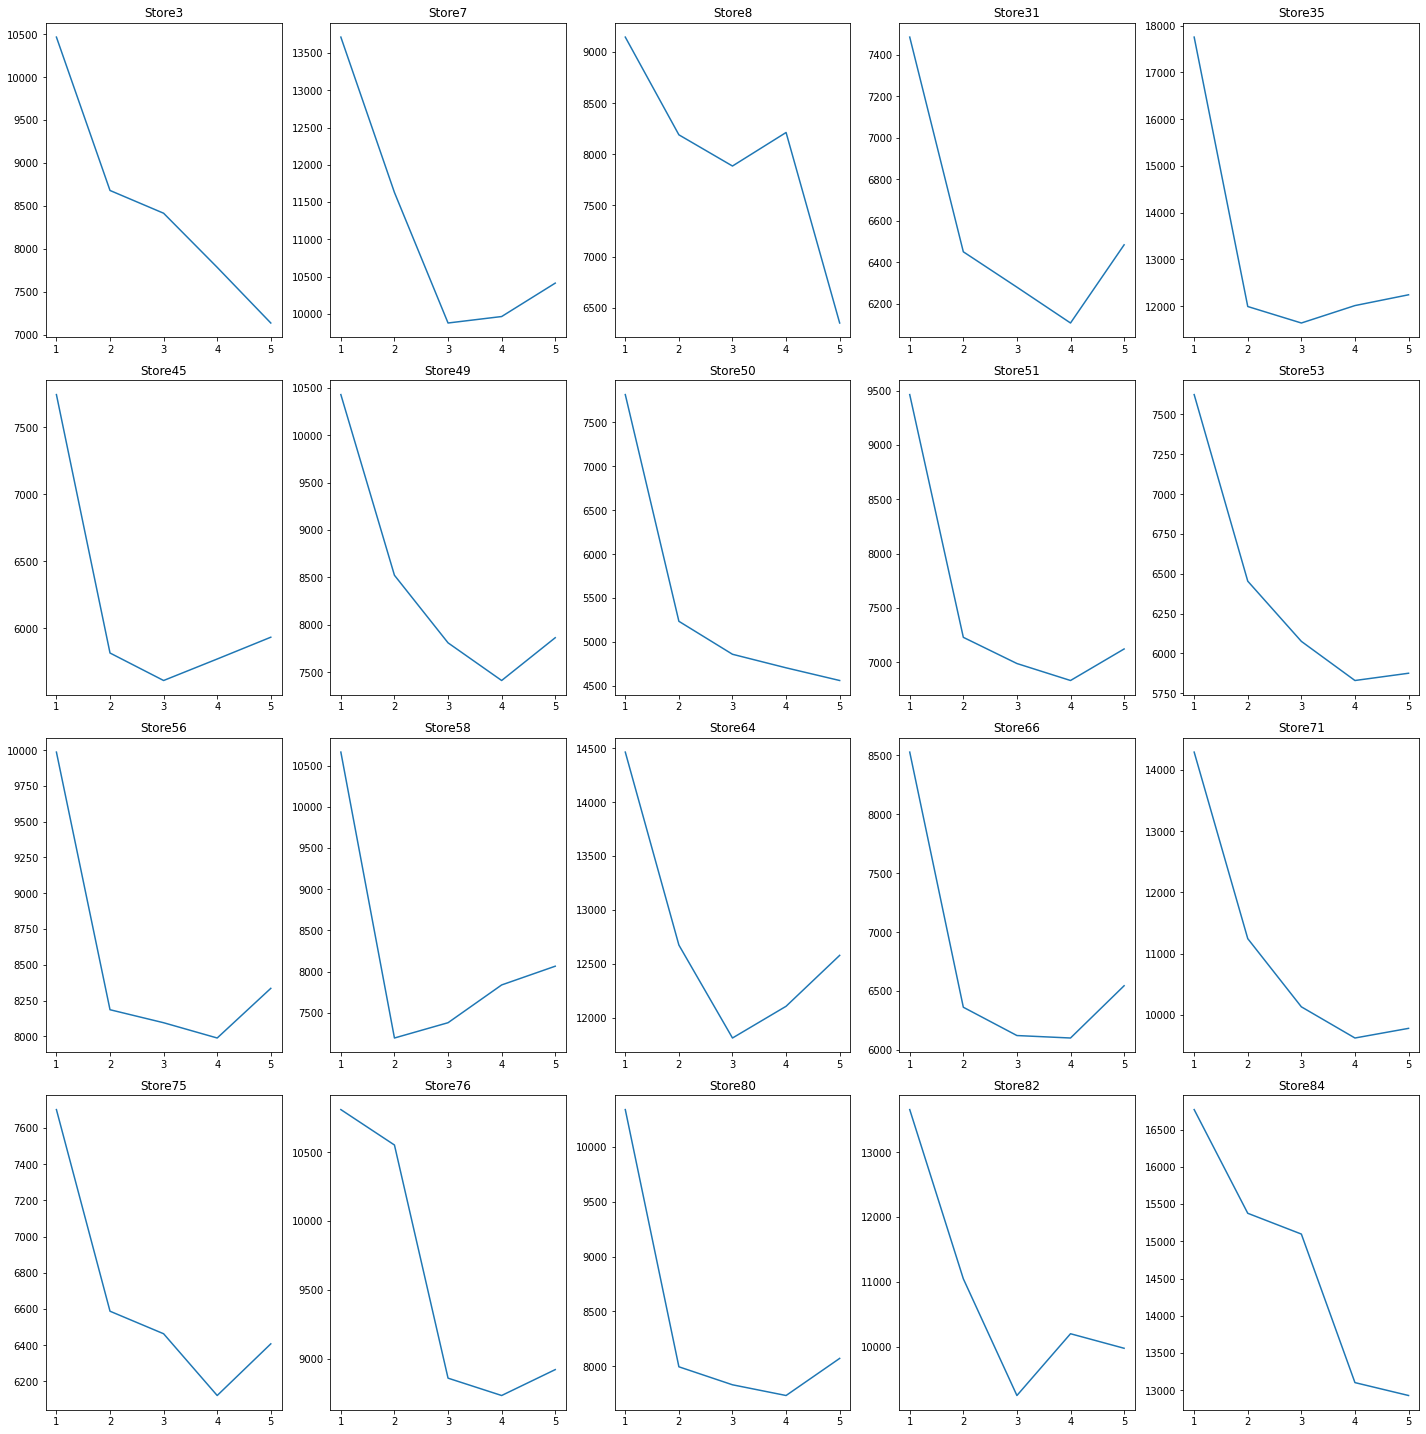

In [ ]:
fig,b =  plt.subplots(4,5,figsize=(20, 20))
k = 0
for i in range(len(b)) :
  for j in range(len(b[i])) :
    fig.tight_layout(pad=1.0)
    b[i][j].set_title('Store'+str(a[k]))
    b[i][j].plot(group.loc[a[k]])
    k+=1

plt.show()
